# 🌸 Pollen Viability Deep Learning Pipeline (YOLOv8)

**Project:** Automated counting of viable (stained) vs. non-viable (pale) pollen grains.
**Author:** Jakub Štenc
**Model:** YOLOv8x (Extra Large)
**Compute Environment:** CESNET MetaCentrum (HPC)

This pipeline performs three main functions:
1.  **Data Management:** Pulls versioned datasets from **CESNET S3 Object Storage** to the high-speed Scratch SSD.
2.  **Training:** Retrains the model on the cluster GPUs using specific biological augmentations.
3.  **Inference:** Detects pollen in new microscope images using dynamic resolution switching.
---

### **PART 1: SETUP & DATA MANAGEMENT**
* **[Step 1: Environment Setup & Data Sync](#step-1)**
    * Installs libraries, connects to S3 (CL4), and downloads the dataset to the fast Scratch SSD.
* **[Step 1b: Create File Browser Shortcut](#step-1b)**
    * 🔗 **Magical Link:** Creates a folder named `_FAST_SCRATCH_LINK` so you can see your SSD files in the browser.
* **[Step 2: Model Initialization](#step-2)**
    * Loads the YOLOv8x (Extra Large) model and verifies GPU availability.
* **[Step 3a: Merge Staged Data](#step-3a)**
    * Checks for new `.zip` uploads in the staging area and merges them into the training set.
* **[Step 3b: Synthetic Negative Samples](#step-3b)**
    * Generates "empty" background images from raw smudge crops to reduce false positives.
* **[Step 3c: Dataset Health Check](#step-3c)**
    * Quarantines unlabeled images and purges corrupted files (e.g., Google Doc links).

### **PART 2: VERIFICATION**
* **[Step 3d: Class Balance Stats](#step-3d)**
    * Plots a bar chart of Viable vs. Non-Viable counts to ensure dataset balance.
* **[Step 3e: Visual Inspection (Ground Truth)](#step-3e)**
    * Draws boxes/polygons on sample images and zips them for manual verification.
* **[Step 4: Generate Configuration](#step-4)**
    * Creates the `data.yaml` file required by YOLO.

### **PART 3: TRAINING & EVALUATION**
* **[Step 5: Start Training](#step-5)**
    * Runs the YOLOv8 training loop (Detection mode) with `agnostic_nms`.

### **PART 4: DEPLOYMENT & BACKUP**
* **[Step 6: Cloud Backup](#step-6)**
    * Uploads the trained weights (`best.pt`) to CESNET S3 storage.
* **[Step 7: Detection](#step-7)**
    * Detects the pollen grains.
* **[Step 8: Routine Detection Tool](#step-8)**
    * Runs the model on new/unseen microscope images and generates a CSV report.

---

# <a id="step-1">🛠️ Step 1: Environment Setup & Data Sync
Run this cell to:
1.  **Install** required libraries (`ultralytics`, `boto3`, `opencv`).
2.  **Connect** to CESNET S3 (Cluster 4).
3.  **Download** the dataset to the high-speed Scratch SSD.
4.  **Configure** global paths for the rest of the notebook.

In [1]:
import sys
import subprocess
import os
import boto3
import shutil
from botocore.client import Config
from getpass import getpass

# --- PART A: ROBUST INSTALLATION ---
# Installs libraries and fixes the "headless" OpenCV crash automatically
print("🔄 Checking libraries... (This may take a minute)")
try:
    import ultralytics
    import boto3
    import cv2
except ImportError:
    print("   Installing dependencies...")
    subprocess.check_call([
        sys.executable, "-m", "pip", "install", 
        "ultralytics", 
        "boto3", 
        "numpy==1.24.4", 
        "opencv-python-headless", 
        "matplotlib", 
        "seaborn", 
        "pandas",
        "--quiet"
    ])
    # Safety Check: Remove conflicting standard OpenCV
    subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "opencv-python"], check=False)
    print("✅ Installation complete.")

# --- PART B: SETUP SCRATCH STORAGE ---
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
print(f"🚀 DETECTED FAST SSD! Using scratch space at: {SCRATCH_DIR}")

# --- PART C: S3 CREDENTIALS (FRESH START) ---
if 'access_key' in locals(): del access_key
if 'secret_key' in locals(): del secret_key

print("\n🔐 Enter CESNET S3 Access Key:")
access_key = getpass().strip() 

print("🔐 Enter CESNET S3 Secret Key:")
secret_key = getpass().strip()

# --- PART D: CONNECT TO S3 (CL4) ---
BUCKET_NAME = 'bucket' 
S3_ENDPOINT = 'https://s3.cl4.du.cesnet.cz'  # <--- Using the CORRECT CL4 endpoint
S3_PREFIX = 'Ostatni/Pollen_viability'

try:
    s3 = boto3.resource('s3',
        endpoint_url=S3_ENDPOINT,
        aws_access_key_id=access_key,
        aws_secret_access_key=secret_key,
        config=Config(signature_version='s3v4')
    )
    
    # Test connection
    list(s3.Bucket(BUCKET_NAME).objects.filter(Prefix=S3_PREFIX).limit(1))
    print(f"✅ Connection Successful to {S3_ENDPOINT}!")

except Exception as e:
    print(f"\n❌ CRITICAL ERROR: S3 Login Failed on CL4.")
    print(f"   Error: {e}")
    raise e 

# --- PART E: DOWNLOAD DATASET ---
local_project_root = os.path.join(SCRATCH_DIR, 'Pollen_viability')
bucket = s3.Bucket(BUCKET_NAME)

print(f"\n⬇️ Syncing '{S3_PREFIX}' from Cloud to SSD...")

count = 0
for obj in bucket.objects.filter(Prefix=S3_PREFIX):
    rel_path = os.path.relpath(obj.key, S3_PREFIX) 
    if rel_path == ".": continue
    
    dest_path = os.path.join(local_project_root, rel_path)
    
    if not os.path.exists(dest_path):
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        bucket.download_file(obj.key, dest_path)
        count += 1
        if count % 500 == 0: print(f"   Downloaded {count} files...", end='\r')

print(f"\n✅ Sync Complete. {count} new files downloaded.")

# --- PART F: DEFINE PATHS ---
dataset_root = os.path.join(local_project_root, 'datasets/pollen_v1')
yaml_path = os.path.join(dataset_root, 'data.yaml')
permanent_save_dir = os.path.join(os.getcwd(), 'runs/detect')

print("-" * 40)
print(f"📂 Dataset Root:   {dataset_root}")
print(f"📝 Config Path:    {yaml_path}")
print(f"💾 Model Backup:   {permanent_save_dir}")
print("-" * 40)
print("🚀 Ready for Step 2!")

🔄 Checking libraries... (This may take a minute)
🚀 DETECTED FAST SSD! Using scratch space at: /scratch.ssd/meow420/job_15813620.pbs-m1

🔐 Enter CESNET S3 Access Key:


 ····················


🔐 Enter CESNET S3 Secret Key:


 ········································


✅ Connection Successful to https://s3.cl4.du.cesnet.cz!

⬇️ Syncing 'Ostatni/Pollen_viability' from Cloud to SSD...
   Downloaded 2500 files...
✅ Sync Complete. 2708 new files downloaded.
----------------------------------------
📂 Dataset Root:   /scratch.ssd/meow420/job_15813620.pbs-m1/Pollen_viability/datasets/pollen_v1
📝 Config Path:    /scratch.ssd/meow420/job_15813620.pbs-m1/Pollen_viability/datasets/pollen_v1/data.yaml
💾 Model Backup:   /auto/vestec1-elixir/home/meow420/Pollen_viability_notebooks/runs/detect
----------------------------------------
🚀 Ready for Step 2!


## <a id="step-1b"></a> 🔗 Step 1b: Create File Browser Shortcut
The Cluster SSD (`$SCRATCHDIR`) is hidden by default. This cell creates a **Symbolic Link** in your file browser so you can verify your files.

* **Action:** Look for a folder named **`_FAST_SCRATCH_LINK`** on the left after running this.
* **Note:** Double-click it to inspect your downloaded dataset.

In [2]:
import os

# 1. Get the secret scratch location
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
current_dir = os.getcwd()

# 2. Define the shortcut name
link_name = os.path.join(current_dir, "_FAST_SCRATCH_LINK")

# 3. Create the shortcut (Force Clean)
try:
    # If the link already exists (even if broken), delete it first
    if os.path.islink(link_name) or os.path.exists(link_name):
        os.unlink(link_name)
    
    # Create fresh link
    os.symlink(SCRATCH_DIR, link_name)
    
    print(f"✅ Shortcut created!")
    print(f"   Go to your file browser on the left.")
    print(f"   Look for the folder: '_FAST_SCRATCH_LINK'")
    print(f"   Double-click it to see your data on the SSD.")

except Exception as e:
    print(f"⚠️ Could not create link: {e}")

print(f"\nReal Location: {SCRATCH_DIR}")

✅ Shortcut created!
   Go to your file browser on the left.
   Look for the folder: '_FAST_SCRATCH_LINK'
   Double-click it to see your data on the SSD.

Real Location: /scratch.ssd/meow420/job_15813620.pbs-m1


# <a id="step-2"></a> 🧠 Step 2: Model Initialization
Here we load the YOLOv8 architecture.
* **Model:** `yolov8x.pt` (Extra large) - Higher accuracy, requires more GPU VRAM.
* **Hardware Check:** Verifies that the NVIDIA GPU is active before loading the heavy model.



In [3]:
import torch
from ultralytics import YOLO

# 1. HARDWARE CHECK
if torch.cuda.is_available():
    print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
    print("🚀 Ready for high-performance training.")
else:
    print("⚠️ WARNING: GPU not detected. Training will be SLOW!")

# 2. LOAD MODEL
# We use 'yolov8x.pt' (Detection) because your data has mixed boxes/polygons.
# Detection handles this best (Segmentation would crash).
model = YOLO('yolov8x.pt')

print("✅ Model loaded successfully.")

✅ GPU Detected: NVIDIA L40S
🚀 Ready for high-performance training.
✅ Model loaded successfully.


# <a id="step-3"></a> 🔄 Step 3: Staging Area & Dataset Organization
This cell manages the data pipeline by merging the stable dataset from S3 with any new updates you upload manually.

**The Workflow:**
1.  **Base Data:** Starts with the full dataset downloaded from CESNET S3 in Step 2.
2.  **Staging Area:** Checks the `./staging_area/` folder for any new `.zip` files (e.g., fresh exports from Roboflow).
3.  **Merge:** Automatically extracts the zip, detects valid image/label pairs, and merges them into the main dataset (skipping duplicates).
4.  **Split:** Reshuffles the entire combined dataset and splits it into **80% Training** and **20% Validation** folders.
5.  **Config:** Generates the `data.yaml` file required by YOLO.

> **How to update the model:**
> Simply upload your new Roboflow zip file into the `staging_area` folder on the left, then run this cell. It will integrate the new data automatically.


## <a id="step-3a"></a> 🔄 Step 3a: Merge Staged Data
This cell checks the `staged_area` folder on the SSD.
* If you uploaded a new `.zip` (e.g., from Roboflow) to S3, Step 1 downloaded it here.
* This script extracts it and merges it into the main `datasets/pollen_v1` folder automatically.

In [4]:
import os
import shutil
import zipfile
import glob
import random
from tqdm import tqdm

# --- 1. SETUP PATHS (ABSOLUTE) ---
# We use the SCRATCH_DIR to ensure we are working on the fast SSD
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
PROJECT_ROOT = os.path.join(SCRATCH_DIR, 'Pollen_viability')

# Where to look for the new zip (Downloaded from S3 in Step 1)
SEARCH_ROOT = os.path.join(PROJECT_ROOT, 'staged_area')

# Where the main dataset lives
DATASET_ROOT = os.path.join(PROJECT_ROOT, 'datasets/pollen_v1')
TRAIN_DIR = os.path.join(DATASET_ROOT, 'train')
VAL_DIR = os.path.join(DATASET_ROOT, 'val')

# Temporary workspace for unzipping
TEMP_DIR = os.path.join(PROJECT_ROOT, 'temp_merge_workspace')
VAL_SPLIT_RATIO = 0.20

print(f"🚀 Checking for new data in: {SEARCH_ROOT}")

# --- 2. FIND THE ZIP FILE ---
if not os.path.exists(SEARCH_ROOT):
    os.makedirs(SEARCH_ROOT, exist_ok=True)

# Look for zips in the staging folder
possible_zips = glob.glob(os.path.join(SEARCH_ROOT, "*.zip"))

# --- 3. MERGE LOGIC ---
if not possible_zips:
    print(f"ℹ️ No .zip files found in staged_area.")
    print("   Proceeding with existing dataset only.")

else:
    roboflow_zip = possible_zips[0]
    print(f"1️⃣ Found new data: {os.path.basename(roboflow_zip)}")

    # --- CLEANUP & UNZIP ---
    if os.path.exists(TEMP_DIR): shutil.rmtree(TEMP_DIR)
    os.makedirs(TEMP_DIR, exist_ok=True)

    print(f"   Unzipping to fast SSD workspace...")
    try:
        with zipfile.ZipFile(roboflow_zip, 'r') as z:
            z.extractall(TEMP_DIR)
    except zipfile.BadZipFile:
        print("❌ Error: The zip file appears corrupted.")
        # Exit or handle error

    # --- HUNT DOWN NEW DATA ---
    found_pairs = []
    print("   Scanning extracted files...")

    # Helper to find matching .txt for a .jpg
    def find_label(img_path, search_dir):
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        # Recursively search for the label file
        for r, d, f in os.walk(search_dir):
            for file in f:
                if file == base_name + ".txt":
                    return os.path.join(r, file)
        return None

    # Walk through the unzipped temp folder
    for root, dirs, files in os.walk(TEMP_DIR):
        for f in files:
            if f.startswith('._'): continue # Skip Mac hidden files
            if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_full_path = os.path.join(root, f)
                lbl_full_path = find_label(img_full_path, TEMP_DIR)
                
                # Only keep if we have both image AND label
                if lbl_full_path:
                    found_pairs.append((img_full_path, lbl_full_path))

    print(f"   Found {len(found_pairs)} valid Image+Label pairs.")

    # --- DUPLICATE CHECK ---
    print("\n2️⃣ Checking for Duplicates...")
    existing_files = set()
    for split in [TRAIN_DIR, VAL_DIR]:
        img_check_dir = os.path.join(split, 'images')
        if os.path.exists(img_check_dir):
            existing_files.update(os.listdir(img_check_dir))

    unique_pairs = []
    skipped_count = 0

    for img_path, lbl_path in found_pairs:
        fname = os.path.basename(img_path)
        if fname in existing_files:
            skipped_count += 1
        else:
            unique_pairs.append((img_path, lbl_path))

    if skipped_count > 0:
        print(f"   ⚠️ Skipped {skipped_count} duplicates.")

    if len(unique_pairs) == 0:
        print("   ℹ️ No new unique images to add.")
    else:
        # --- SPLIT & MERGE ---
        print("\n3️⃣ Splitting and Merging...")

        # Shuffle and Split
        random.shuffle(unique_pairs)
        split_idx = int(len(unique_pairs) * VAL_SPLIT_RATIO)
        
        # Ensure at least one validation image if batch is small
        if len(unique_pairs) > 0 and split_idx == 0:
             split_idx = 1
             
        val_batch = unique_pairs[:split_idx]
        train_batch = unique_pairs[split_idx:]

        print(f"   Adding {len(train_batch)} to TRAIN.")
        print(f"   Adding {len(val_batch)} to VAL.")

        def move_batch(batch, destination_dir):
            img_dest = os.path.join(destination_dir, 'images')
            lbl_dest = os.path.join(destination_dir, 'labels')
            os.makedirs(img_dest, exist_ok=True)
            os.makedirs(lbl_dest, exist_ok=True)

            for img, lbl in batch:
                shutil.copy2(img, os.path.join(img_dest, os.path.basename(img)))
                shutil.copy2(lbl, os.path.join(lbl_dest, os.path.basename(lbl)))

        move_batch(train_batch, TRAIN_DIR)
        move_batch(val_batch, VAL_DIR)

        print("\n✅ SUCCESS! Dataset updated.")
        print("   (Note: Zip file remains in staged_area. Delete manually if needed.)")

    # Cleanup temp workspace
    if os.path.exists(TEMP_DIR): shutil.rmtree(TEMP_DIR)

🚀 Checking for new data in: /scratch.ssd/meow420/job_15813620.pbs-m1/Pollen_viability/staged_area
1️⃣ Found new data: Viable_pollen.v14i.yolov8.zip
   Unzipping to fast SSD workspace...
   Scanning extracted files...
   Found 409 valid Image+Label pairs.

2️⃣ Checking for Duplicates...
   ⚠️ Skipped 160 duplicates.

3️⃣ Splitting and Merging...
   Adding 200 to TRAIN.
   Adding 49 to VAL.

✅ SUCCESS! Dataset updated.
   (Note: Zip file remains in staged_area. Delete manually if needed.)


## <a id="step-3b"></a> 🧪 Step 3b: Synthetic Negative Samples
We generate "Empty" images to reduce false positives.

**The Workflow:**
1.  **Input:** Takes raw crops of dirt/smudges from the `./smudges_raw` folder.
2.  **Synthesis:** Pastes each smudge onto a standard 640x640 gray background to simulate a microscope slide.
3.  **Empty Labels:** Creates a corresponding `.txt` label file that is completely empty. This explicitly teaches YOLO: *"There is nothing to detect here."*
4.  **Integration:** Randomly splits these synthetic negatives (80% Train / 20% Val) and mixes them into the main dataset.






In [5]:
import os
import cv2
import numpy as np
import random
import shutil
from tqdm import tqdm

# --- 1. SETUP PATHS ---
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
PROJECT_ROOT = os.path.join(SCRATCH_DIR, 'Pollen_viability')

# Input: Where the raw dirt crops are (Downloaded from S3)
SMUDGES_RAW_DIR = os.path.join(PROJECT_ROOT, 'smudges_raw')

# Output: Your main dataset
DATASET_ROOT = os.path.join(PROJECT_ROOT, 'datasets/pollen_v1')
TRAIN_IMG_DIR = os.path.join(DATASET_ROOT, 'train/images')
TRAIN_LBL_DIR = os.path.join(DATASET_ROOT, 'train/labels')
VAL_IMG_DIR = os.path.join(DATASET_ROOT, 'val/images')
VAL_LBL_DIR = os.path.join(DATASET_ROOT, 'val/labels')

# --- 2. CONFIGURATION ---
CANVAS_SIZE = 640
BG_COLOR = (200, 200, 200) # Light gray (Simulates microscope background)
VAL_SPLIT = 0.20

print(f"🧪 Generating Synthetic Negatives from: {SMUDGES_RAW_DIR}")

# --- 3. GENERATION LOGIC ---
if not os.path.exists(SMUDGES_RAW_DIR):
    print(f"⚠️ Warning: '{SMUDGES_RAW_DIR}' not found.")
    print("   Skipping smudge generation. (Did Step 1 download the 'smudges_raw' folder?)")
else:
    raw_files = [f for f in os.listdir(SMUDGES_RAW_DIR) if f.lower().endswith(('.jpg', '.png'))]
    
    if not raw_files:
        print("ℹ️ No smudge images found. Skipping.")
    else:
        print(f"   Found {len(raw_files)} raw smudge inputs.")
        
        count_created = 0
        
        for fname in tqdm(raw_files, desc="Synthesizing"):
            # 1. Load the smudge image
            img_path = os.path.join(SMUDGES_RAW_DIR, fname)
            img = cv2.imread(img_path)
            
            if img is None: continue

            # 2. Create a blank gray canvas
            canvas = np.full((CANVAS_SIZE, CANVAS_SIZE, 3), BG_COLOR, dtype=np.uint8)
            
            # 3. Paste smudge in the center (preserving aspect ratio)
            h, w = img.shape[:2]
            scale = min(CANVAS_SIZE / h, CANVAS_SIZE / w) * 0.8 # Scale to 80% of canvas
            new_w, new_h = int(w * scale), int(h * scale)
            resized = cv2.resize(img, (new_w, new_h))
            
            # Center coordinates
            y_offset = (CANVAS_SIZE - new_h) // 2
            x_offset = (CANVAS_SIZE - new_w) // 2
            
            canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
            
            # 4. Decide Train vs Val
            is_val = random.random() < VAL_SPLIT
            target_img_dir = VAL_IMG_DIR if is_val else TRAIN_IMG_DIR
            target_lbl_dir = VAL_LBL_DIR if is_val else TRAIN_LBL_DIR
            
            # 5. Save Image
            out_name = f"synthetic_neg_{fname}"
            cv2.imwrite(os.path.join(target_img_dir, out_name), canvas)
            
            # 6. Create EMPTY Label File
            # This is the magic part: An empty file tells YOLO "Nothing to see here"
            lbl_name = os.path.splitext(out_name)[0] + ".txt"
            open(os.path.join(target_lbl_dir, lbl_name), 'w').close()
            
            count_created += 1

        print(f"✅ Generated {count_created} synthetic negative samples.")

🧪 Generating Synthetic Negatives from: /scratch.ssd/meow420/job_15813620.pbs-m1/Pollen_viability/smudges_raw
   Found 415 raw smudge inputs.


Synthesizing: 100%|██████████| 415/415 [00:04<00:00, 85.09it/s]

✅ Generated 415 synthetic negative samples.


## <a id="step-3c"></a> 🧹 Step 3c: Dataset Health Check
"Garbage In, Garbage Out."
1.  **Quarantine:** Moves images without labels to `quarantine_unlabeled`.
2.  **Purge:** Deletes corrupted files (like hidden `.gdoc` links) that crash training.

In [6]:
import os
import shutil

# --- 1. SETUP PATHS ---
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
dataset_root = os.path.join(SCRATCH_DIR, 'Pollen_viability/datasets/pollen_v1')

train_img_dir = os.path.join(dataset_root, 'train/images')
train_lbl_dir = os.path.join(dataset_root, 'train/labels')
val_img_dir   = os.path.join(dataset_root, 'val/images')
val_lbl_dir   = os.path.join(dataset_root, 'val/labels')

# Quarantine folder for bad data
quarantine_dir = os.path.join(SCRATCH_DIR, 'Pollen_viability/quarantine_unlabeled')
os.makedirs(quarantine_dir, exist_ok=True)

print(f"🧹 Scanning dataset at: {dataset_root}")

# --- 2. ORPHAN CHECK (Image with no Label) ---
moved_count = 0
image_files = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for img_file in image_files:
    label_file = os.path.splitext(img_file)[0] + ".txt"
    label_path = os.path.join(train_lbl_dir, label_file)

    if not os.path.exists(label_path):
        # Move bad image to quarantine
        shutil.move(os.path.join(train_img_dir, img_file), os.path.join(quarantine_dir, img_file))
        moved_count += 1

if moved_count > 0:
    print(f"⚠️ Moved {moved_count} unlabeled images to Quarantine.")
else:
    print("✅ All training images have labels.")

# --- 3. GOOGLE DOC CHECK (Corrupted Files) ---
total_deleted = 0
folders_to_check = [train_lbl_dir, val_lbl_dir]

for folder in folders_to_check:
    if not os.path.exists(folder): continue
    
    for f in os.listdir(folder):
        file_path = os.path.join(folder, f)
        
        # Check explicit extension or hidden gdoc content
        is_gdoc = f.endswith('.gdoc')
        if not is_gdoc and os.path.isfile(file_path) and not f.endswith('.txt'):
            try:
                with open(file_path, 'r', errors='ignore') as check:
                    if "google" in check.read(100).lower(): is_gdoc = True
            except: pass
            
        if is_gdoc:
            print(f"   ❌ Deleting corrupted file: {f}")
            os.remove(file_path)
            total_deleted += 1

print(f"✅ Cleanup Complete. Deleted {total_deleted} corrupted files.")

🧹 Scanning dataset at: /scratch.ssd/meow420/job_15813620.pbs-m1/Pollen_viability/datasets/pollen_v1
✅ All training images have labels.
✅ Cleanup Complete. Deleted 0 corrupted files.


## <a id="step-3d"></a> 📊 Step 3d: Visualization & Statistics
Before training, we check the data balance.
1.  **Plot:** Shows the ratio of Viable vs. Non-Viable pollen.
2.  **Draw Labels:** Creates a `.zip` of images with bounding boxes drawn, so you can verify annotation quality manually.

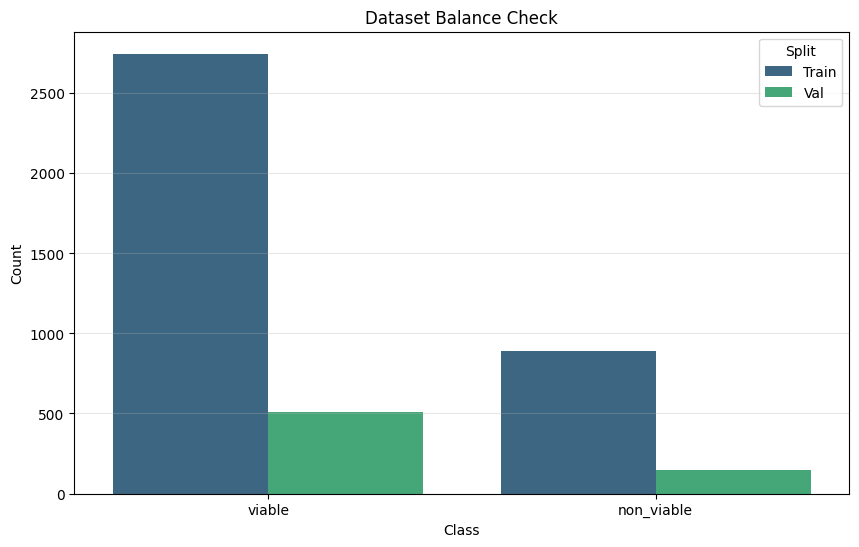

Total: 3636 Train | 656 Val


In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import yaml

# --- 1. SETUP PATHS ---
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
dataset_root = os.path.join(SCRATCH_DIR, 'Pollen_viability/datasets/pollen_v1')
yaml_path = os.path.join(dataset_root, 'data.yaml')

# --- 2. LOAD NAMES ---
# We try to load names from the YAML, or default if missing
try:
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
        names = data_config.get('names', {0: 'viable', 1: 'non_viable'})
        # Normalize to dict {0: 'name'}
        class_map = names if isinstance(names, dict) else {i: n for i, n in enumerate(names)}
except:
    class_map = {0: 'viable', 1: 'non_viable'}

# --- 3. COUNTING ---
def count_labels(folder_path):
    cnt = Counter()
    if not os.path.exists(folder_path): return cnt
    
    for file in [f for f in os.listdir(folder_path) if f.endswith('.txt')]:
        with open(os.path.join(folder_path, file), 'r') as f:
            for line in f:
                if line.strip(): cnt[int(line.split()[0])] += 1
    return cnt

train_counts = count_labels(os.path.join(dataset_root, 'train/labels'))
val_counts = count_labels(os.path.join(dataset_root, 'val/labels'))

# --- 4. PLOT ---
data_rows = []
for split, counts in [('Train', train_counts), ('Val', val_counts)]:
    for cid, count in counts.items():
        data_rows.append({'Class': class_map.get(cid, str(cid)), 'Count': count, 'Split': split})

if data_rows:
    df = pd.DataFrame(data_rows)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Class', y='Count', hue='Split', palette='viridis')
    plt.title('Dataset Balance Check')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    print(f"Total: {sum(train_counts.values())} Train | {sum(val_counts.values())} Val")
else:
    print("⚠️ No labels found to plot.")

## <a id="step-3e"></a> 👁️ Step 3e: Visual Inspection (Ground Truth Check)

Before trusting the model, we must trust the data. This script takes the first 20 images from your training and validation sets and physically "draws" the label annotations onto them.

1.  **Green Boxes/Lines: Viable Pollen (Class 0)**

2.  **Red Boxes/Lines: Non-Viable Pollen (Class 1)**

3.  **Hybrid Handling: It automatically detects if a label is a Polygon (segmentation) or a Box (detection) and draws it correctly.**

Outcome: A zip file (visual_check_images.zip) will be created in your file browser. Download it to your laptop to verify that boxes are centered on the pollen grains and not shifted or corrupted.

In [8]:
import os
import cv2
import shutil
import numpy as np

# --- 1. SETUP PATHS ---
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
dataset_root = os.path.join(SCRATCH_DIR, 'Pollen_viability/datasets/pollen_v1')

# Output location (Temporary folder)
output_root = os.path.join(SCRATCH_DIR, 'Pollen_viability/visual_check_output')

COLORS = {0: (0, 255, 0), 1: (0, 0, 255)}  # Green/Red
NAMES = {0: 'Viable', 1: 'Non-Viable'}

def draw_labels(split):
    img_dir = os.path.join(dataset_root, split, 'images')
    lbl_dir = os.path.join(dataset_root, split, 'labels')
    save_dir = os.path.join(output_root, split)
    
    if os.path.exists(save_dir): shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)
    
    if not os.path.exists(img_dir): return

    print(f"🎨 Drawing labels for '{split}'...")
    
    # Process only first 20 images to save time
    for img_file in sorted(os.listdir(img_dir)): 
        if not img_file.lower().endswith(('.jpg', '.png')): continue
        
        img = cv2.imread(os.path.join(img_dir, img_file))
        if img is None: continue
        h, w = img.shape[:2]
        
        lbl_file = os.path.splitext(img_file)[0] + '.txt'
        lbl_path = os.path.join(lbl_dir, lbl_file)
        
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts: continue
                    
                    cls_id = int(parts[0])
                    coords = [float(x) for x in parts[1:]]
                    color = COLORS.get(cls_id, (255, 255, 255))
                    
                    # POLYGON (Segmentation)
                    if len(coords) > 4:
                        pts = np.array([[int(coords[i]*w), int(coords[i+1]*h)] for i in range(0, len(coords), 2)], np.int32)
                        cv2.polylines(img, [pts.reshape((-1, 1, 2))], True, color, 2)
                    
                    # BOX (Detection)
                    else:
                        cx, cy, bw, bh = coords
                        x1, y1 = int((cx-bw/2)*w), int((cy-bh/2)*h)
                        x2, y2 = int((cx+bw/2)*w), int((cy+bh/2)*h)
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        cv2.imwrite(os.path.join(save_dir, img_file), img)

# --- RUN ---
draw_labels('train')
draw_labels('val')

# --- ZIP FOR DOWNLOAD ---
zip_path = os.path.join(os.getcwd(), 'visual_check_images') # Save to Home Dir
shutil.make_archive(zip_path, 'zip', output_root)
print(f"✅ Done! Download 'visual_check_images.zip' from your file browser to inspect.")

🎨 Drawing labels for 'train'...
🎨 Drawing labels for 'val'...
✅ Done! Download 'visual_check_images.zip' from your file browser to inspect.


# <a id="step-4"></a> ⚙️ Step 4: Configure Model Hyperparameters
This cell generates the `data.yaml` file required by YOLO. It defines the paths to your Train/Val folders and the class names.

* **Classes:** `['viable', 'non_viable']`
* **Path:** Points to your Google Drive dataset location.

In [9]:
import yaml
import os

SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
dataset_root = os.path.join(SCRATCH_DIR, 'Pollen_viability/datasets/pollen_v1')
yaml_path = os.path.join(dataset_root, 'data.yaml')

data_config = {
    'path': dataset_root,
    'train': 'train/images',
    'val': 'val/images',
    'nc': 2,
    'names': ['viable', 'non_viable']
}

with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print(f"✅ Config saved to: {yaml_path}")

✅ Config saved to: /scratch.ssd/meow420/job_15548720.pbs-m1/Pollen_viability/datasets/pollen_v1/data.yaml


# <a id="step-5"></a> 🏋️‍♀️ Step 5: Train the Model
This process will take 1-3 hours depending on the model size.

**Biological Hyperparameters:**
We use specific augmentations to make the model robust to microscope variations:
* `degrees=180`: Pollen has no "up" or "down" (rotational invariance).
* `flipud=0.5`: Vertical flipping enabled.
* `hsv_s=0.1`: **Low Saturation Noise**. We limit color augmentation because color (Dark vs. Pale) is the primary viability signal.
* `patience=50`: Early Stopping is enabled. If the model stops improving for 50 epochs, training stops to prevent overfitting.

In [10]:
from ultralytics import YOLO
import os

SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
dataset_root = os.path.join(SCRATCH_DIR, 'Pollen_viability/datasets/pollen_v1')
yaml_path = os.path.join(dataset_root, 'data.yaml')
project_save_dir = os.path.join(os.getcwd(), 'runs/detect')

print(f"🚀 Starting training... Saving to: {project_save_dir}")

results = model.train(
    data=yaml_path,
    epochs=300,
    patience=50,
    batch=16,
    imgsz=640,
    device=0,
    task='detect',
    name='pollen_v1_run2', 
    project=project_save_dir,
    agnostic_nms=True, 
    val=True,
    degrees=180,
    flipud=0.5,
    fliplr=0.5,
    mosaic=1.0,
    close_mosaic=20
)

🚀 Starting training... Saving to: /auto/vestec1-elixir/home/meow420/Pollen_viability_notebooks/runs/detect
New https://pypi.org/project/ultralytics/8.3.248 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.240 🚀 Python-3.10.12 torch-2.3.0a0+6ddf5cf85e.nv24.04 CUDA:0 (NVIDIA A40, 45488MiB)
engine/trainer: agnostic_nms=True, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/scratch.ssd/meow420/job_15548720.pbs-m1/Pollen_viability/datasets/pollen_v1/data.yaml, degrees=180, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=Non

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Plotting labels to /auto/vestec1-elixir/home/meow420/Pollen_viability_notebooks/runs/detect/pollen_v1_run27/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /auto/vestec1-elixir/home/meow420/Pollen_viability_notebooks/runs/detect/pollen_v1_run27
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/300      12.1G      1.469      1.991      1.508         28        640: 100% ━━━━━━━━━━━━ 56/56 1.4it/s 41.1s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.6it/s 2.7s0.4ss
                   all        219        662          0      

# <a id="step-6"></a> 💾 Step 6: Backup to S3

This script automatically uploads your trained model (best.pt) to the cloud so you don't lose it if the session disconnects.

In [18]:
# -----------------------------------------------------------------------------
# 💾 STEP 6: CLOUD BACKUP (S3)
# -----------------------------------------------------------------------------
# Saves 'best.pt' to CESNET S3 storage.
# -----------------------------------------------------------------------------

import os
import sys
import shutil
import subprocess
from datetime import datetime
from getpass import getpass

# --- 1. CONFIGURATION ---
TRAINING_NAME = 'pollen_v1_run27'
BUCKET_NAME = 'bucket'
S3_ENDPOINT = 'https://s3.cl4.du.cesnet.cz' 

# --- 2. AUTHENTICATION ---
if 'access_key' not in locals():
    print("🔐 Enter S3 Keys (Input hidden):")
    access_key = getpass("Access Key: ").strip()
    secret_key = getpass("Secret Key: ").strip()

# --- 3. PATH SETUP ---
working_dir = os.getcwd()
source_weight = os.path.join(working_dir, 'runs/detect', TRAINING_NAME, 'weights/best.pt')
date_str = datetime.now().strftime("%Y-%m-%d")
s3_path = f"s3://{BUCKET_NAME}/Ostatni/Pollen_viability/trained_models/pollen_yolo_{date_str}.pt"

# Find AWS Tool
aws_executable = shutil.which('aws')
if not aws_executable:
    # Check user local bin
    user_bin = os.path.expanduser('~/.local/bin/aws')
    if os.path.exists(user_bin):
        aws_executable = user_bin
    else:
        print("⚙️ Installing AWS CLI...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "awscli", "--quiet"])
        aws_executable = user_bin if os.path.exists(user_bin) else 'aws'

# --- 4. EXECUTION ---
if os.path.exists(source_weight):
    print(f"☁️ Uploading to {S3_ENDPOINT}...")
    
    cmd = [
        aws_executable, 's3', 'cp', 
        source_weight, s3_path, 
        '--endpoint-url', S3_ENDPOINT,
        '--no-verify-ssl' # Fix for cluster SSL strictness
    ]
    
    env = os.environ.copy()
    env['AWS_ACCESS_KEY_ID'] = access_key
    env['AWS_SECRET_ACCESS_KEY'] = secret_key
    env['AWS_DEFAULT_REGION'] = 'us-east-1'

    try:
        proc = subprocess.run(cmd, check=True, text=True, capture_output=True, env=env)
        print("✅ SUCCESS! Model backed up.")
        print(f"   {s3_path}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Upload Failed: {e.stderr}")
else:
    print(f"❌ Model file not found: {source_weight}")

✅ AWS CLI found at: /storage/praha1/home/meow420/.local/bin/aws
🔍 Looking for model at: /auto/vestec1-elixir/home/meow420/Pollen_viability_notebooks/runs/detect/pollen_v1_run27/weights/best.pt
☁️ Starting Robust Upload to https://s3.cl4.du.cesnet.cz...
   Target: s3://bucket/Ostatni/Pollen_viability/trained_models/pollen_yolo_2026-01-08.pt
❌ Upload Failed.
Error Output:
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 's3.cl4.du.cesnet.cz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 's3.cl4.du.cesnet.cz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.war

# <a id="step-7"> </a> Step 7: High-Resolution Tiled Detection

## 🧠 How It Works: The "Tile & Stitch" Strategy

Standard YOLO models resize images to a fixed square (e.g., `640x640`) before analysis. For huge microscope scans (e.g., `5000x4000` pixels), this shrinking causes **"The Squish Effect"**: small pollen grains become blurry dots, losing the texture details needed to distinguish viable from non-viable grains.

To solve this, we use a **Tiling Strategy** that treats the large image like a puzzle.

### 1. The Tiling Process
Instead of shrinking the whole image, the script cuts it into overlapping **tiles** (e.g., `1600x1600` pixels).
* **Full Resolution:** The AI sees each tile at 100% zoom, preserving the texture of shriveled vs. healthy grains.
* **Overlap:** Tiles overlap by ~20% to ensure grains sitting on the "cut line" aren't chopped in half.

### 2. The "Border Patrol" (Artifact Removal)
A common side-effect of tiling is **Double Counting** (Edge Artifacts). A grain on the edge of "Tile A" often appears again on the edge of "Tile B."
To fix this, we apply a specific rule during detection:
* **The Rule:** If a detection box touches the *internal* edge of a tile (within a 10px margin), it is **discarded**.
* **The Logic:** If a grain is on the edge of Tile A, it will be sitting safely in the **center** of Tile B (due to the overlap). We wait for the centered detection to avoid duplicates.

### 3. Global Stitching & NMS
Once all tiles are processed:
1.  **Stitching:** We convert the "local" tile coordinates (x, y) back to "global" image coordinates.
2.  **Global NMS (Non-Maximum Suppression):** A final cleanup pass checks the entire map. If any remaining boxes overlap significantly (IoU > 0.45), the code assumes they are duplicates and merges them.

---
**✅ Result:** A seamless, high-resolution map of the entire slide with no missing grains and no double-counting.

In [20]:
# -----------------------------------------------------------------------------
# 🔬 STEP 7: HIGH-RES POLLEN DETECTION (TILED STRATEGY)
# -----------------------------------------------------------------------------
# 📖 HOW IT WORKS:
# 1. TILING: Large images (>2000px) are cut into 1600x1600 tiles to preserve resolution.
# 2. BORDER PATROL: Detections touching the *internal* edge of a tile are ignored 
#    to prevent double-counting (the neighboring tile will detect them centrally).
# 3. GLOBAL NMS: A final merge step combines overlapping boxes from adjacent tiles.
# -----------------------------------------------------------------------------

import os
import cv2
import pandas as pd
import shutil
import numpy as np
import torch
from ultralytics import YOLO
from torchvision.ops import nms

# --- 1. USER CONFIGURATION ---
# Define the run you want to use
TRAINING_NAME = 'pollen_v1_run27' 

# Detection thresholds
CONF_THRESHOLD = 0.25        # Minimum confidence to count a grain
IOU_MERGE_THRESHOLD = 0.45   # Overlap required to merge duplicate boxes
TILE_SIZE = 1600             # Size of chunks for large images
BORDER_MARGIN = 10           # Pixels from tile edge to ignore (Border Patrol)

# Visual settings
COLOR_VIABLE = (0, 200, 0)      # Green
COLOR_NON_VIABLE = (0, 0, 255)  # Red

# --- 2. SETUP PATHS ---
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
PROJECT_ROOT = os.path.join(SCRATCH_DIR, 'Pollen_viability')

# Automatic Model Path Discovery
try:
    # First check current directory
    model_path = os.path.join(os.getcwd(), 'runs/detect', TRAINING_NAME, 'weights/best.pt')
    if not os.path.exists(model_path):
        # Fallback to specific fixed path if needed
        model_path = os.path.join(os.getcwd(), 'runs/detect/pollen_v1_run3_fixed_mosaic/weights/best.pt')
except Exception:
    raise FileNotFoundError(f"❌ Could not locate 'best.pt' for run: {TRAINING_NAME}")

# Input/Output Directories
raw_image_source = os.path.join(PROJECT_ROOT, 'detect_images')
working_image_dir = os.path.join(SCRATCH_DIR, 'detect_work_dir')
save_result_dir = os.path.join(SCRATCH_DIR, 'detected_results')
output_csv_path = os.path.join(SCRATCH_DIR, 'pollen_counts.csv')

# Reset Directories
if os.path.exists(working_image_dir): shutil.rmtree(working_image_dir)
if os.path.exists(save_result_dir): shutil.rmtree(save_result_dir)
os.makedirs(working_image_dir, exist_ok=True)
os.makedirs(save_result_dir, exist_ok=True)

# Copy Images to Scratch (Fast SSD)
if os.path.exists(raw_image_source) and os.listdir(raw_image_source):
    for f in os.listdir(raw_image_source):
        if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif')):
            shutil.copy2(os.path.join(raw_image_source, f), working_image_dir)
else:
    print(f"❌ No images found in '{raw_image_source}'. Please upload images first!")

# --- 3. HELPER FUNCTION: TILING ---
def get_tiles(img, tile_size=1600, overlap=0.2):
    """Splits image into overlapping tiles."""
    h, w = img.shape[:2]
    tiles = []
    stride = int(tile_size * (1 - overlap))
    
    y_starts = list(range(0, h, stride))
    x_starts = list(range(0, w, stride))
    
    # Clamp last tile to edge
    if y_starts[-1] + tile_size < h: y_starts[-1] = h - tile_size
    if x_starts[-1] + tile_size < w: x_starts[-1] = w - tile_size

    for y in y_starts:
        for x in x_starts:
            y = max(0, y); x = max(0, x)
            tile = img[y:y+tile_size, x:x+tile_size]
            tiles.append((x, y, tile))
    return tiles

# --- 4. EXECUTION ---
print(f"🔮 Loading Model: {os.path.basename(model_path)}")
model = YOLO(model_path)

image_files = [f for f in os.listdir(working_image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
data_rows = []

print(f"🚀 Starting Analysis on {len(image_files)} images...")

for i, img_file in enumerate(image_files):
    # Progress indicator
    print(f"   [{i+1}/{len(image_files)}] Processing {img_file}...", end='\r')
    
    img_path = os.path.join(working_image_dir, img_file)
    original_img = cv2.imread(img_path)
    if original_img is None: continue
    
    h_orig, w_orig = original_img.shape[:2]
    
    # 🧠 INTELLIGENT MODE SWITCH
    # If image is huge (>2000px), use Tiling. If small, use Standard.
    if w_orig > 2000 or h_orig > 2000:
        # --- MODE: TILING ---
        tile_list = get_tiles(original_img, tile_size=TILE_SIZE, overlap=0.25)
        all_boxes, all_scores, all_cls = [], [], []
        
        for (tx, ty, tile) in tile_list:
            results = model(tile, verbose=False, imgsz=TILE_SIZE, conf=CONF_THRESHOLD)
            
            for box in results[0].boxes:
                lx1, ly1, lx2, ly2 = box.xyxy[0].tolist()
                
                # 🛡️ BORDER PATROL: Ignore edge detections
                on_left = (lx1 < BORDER_MARGIN) and (tx > 0)
                on_right = (lx2 > TILE_SIZE - BORDER_MARGIN) and (tx + TILE_SIZE < w_orig)
                on_top = (ly1 < BORDER_MARGIN) and (ty > 0)
                on_bottom = (ly2 > TILE_SIZE - BORDER_MARGIN) and (ty + TILE_SIZE < h_orig)
                
                if not (on_left or on_right or on_top or on_bottom):
                    # Add to global list
                    all_boxes.append([lx1 + tx, ly1 + ty, lx2 + tx, ly2 + ty])
                    all_scores.append(float(box.conf[0]))
                    all_cls.append(int(box.cls[0]))
        
        # Global NMS Cleanup
        if all_boxes:
            boxes_t = torch.tensor(all_boxes)
            scores_t = torch.tensor(all_scores)
            keep = nms(boxes_t, scores_t, IOU_MERGE_THRESHOLD)
            final_boxes = boxes_t[keep].numpy()
            final_scores = scores_t[keep].numpy()
            final_cls = torch.tensor(all_cls)[keep].numpy()
        else:
            final_boxes, final_scores, final_cls = [], [], []

    else:
        # --- MODE: STANDARD ---
        results = model(img_path, verbose=False, imgsz=1280, conf=CONF_THRESHOLD)
        if results[0].boxes:
            final_boxes = results[0].boxes.xyxy.cpu().numpy()
            final_scores = results[0].boxes.conf.cpu().numpy()
            final_cls = results[0].boxes.cls.cpu().numpy()
        else:
            final_boxes, final_scores, final_cls = [], [], []

    # --- DRAW & STATS ---
    v_count, nv_count = 0, 0
    
    for j in range(len(final_boxes)):
        x1, y1, x2, y2 = map(int, final_boxes[j])
        conf = final_scores[j]
        cls_id = int(final_cls[j])
        
        label_text = f"{'V' if cls_id==0 else 'NV'} {conf:.2f}"
        color = COLOR_VIABLE if cls_id == 0 else COLOR_NON_VIABLE
        
        if cls_id == 0: v_count += 1
        else: nv_count += 1
            
        cv2.rectangle(original_img, (x1, y1), (x2, y2), color, 4)
        if w_orig < 5000: # Only draw text if readable
            cv2.putText(original_img, label_text, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imwrite(os.path.join(save_result_dir, img_file), original_img)
    
    total = v_count + nv_count
    data_rows.append({
        'filename': img_file,
        'viable': v_count,
        'non_viable': nv_count,
        'total': total,
        'viability_%': round((v_count/total*100), 1) if total > 0 else 0
    })

# --- 5. SAVE & ZIP ---
if data_rows:
    df = pd.DataFrame(data_rows)
    df.to_csv(output_csv_path, index=False)
    
    zip_name = f"Results_FINAL_{TRAINING_NAME}"
    output_zip = os.path.join(os.getcwd(), zip_name)
    shutil.make_archive(output_zip, 'zip', save_result_dir)
    
    print(f"\n✅ DONE! Results ready.")
    print(f"   📂 Zip File: {zip_name}.zip")
    print(f"   📊 CSV File: {output_csv_path}")
    print(df.head())
else:
    print("\n⚠️ No data generated. Check input images.")

🔮 Loading Model: best.pt
🚀 Starting Analysis on 556 images...
   [556/556] Processing 8-9-G_4x_C.jpg.......
✅ DONE! Results ready.
   📂 Zip File: Results_FINAL_pollen_v1_run27.zip
   📊 CSV File: /scratch.ssd/meow420/job_15720009.pbs-m1/pollen_counts.csv
          filename  viable  non_viable  total  viability_%
0  1-7-E_S4x_B.jpg     130           4    134         97.0
1  1-1-B_S4x_A.jpg      34           0     34        100.0
2  1-8-H_S4x_A.jpg      43          23     66         65.2
3  1-1-B_S4x_B.jpg      40           0     40        100.0
4  1-7-E_S4x_C.jpg     113           2    115         98.3


## <a id="step-8"></a> 📦 Step 8: Quick Zip for Download

Run this to verify your detection results.

In [5]:
import shutil
import os
from datetime import datetime

# --- CONFIGURATION ---
SCRATCH_DIR = os.environ.get('SCRATCHDIR', '.')
source_images = os.path.join(SCRATCH_DIR, 'detected_results')

# Destination: Your current folder (Visible in the file browser)
destination_dir = os.getcwd() 
timestamp = datetime.now().strftime("%H-%M")
zip_filename = f"CHECK_ME_results_{timestamp}"
output_zip_path = os.path.join(destination_dir, zip_filename)

# --- EXECUTION ---
print(f"📦 Zipping results from SSD: {source_images}")

if os.path.exists(source_images) and len(os.listdir(source_images)) > 0:
    # Create Zip directly in Home Dir
    shutil.make_archive(output_zip_path, 'zip', source_images)
    
    print(f"✅ DONE! A new zip file has appeared in your file browser:")
    print(f"   📂 {zip_filename}.zip")
    print("   (Right-click it and choose 'Download' to check the images)")
else:
    print(f"❌ Error: No images found in {source_images}")
    print("   Did the detection step finish successfully?")

📦 Zipping results from SSD: /scratch.ssd/meow420/job_15720009.pbs-m1/detected_results
✅ DONE! A new zip file has appeared in your file browser:
   📂 CHECK_ME_results_19-57.zip
   (Right-click it and choose 'Download' to check the images)
